### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

In [261]:
!pip3 install textblob
!pip3 install gensim
!pip3 install testfixtures
!pip3 install negspacy

     |████████████████████████████████| 220 kB 6.7 MB/s eta 0:00:01


  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158997 sha256=951e227225fc5dc21c71cb73ecebf6c63863977acf34309931a3c864b7119338
  Stored in directory: /Users/Sayuri/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud


In [486]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.util import ngrams
from nltk import FreqDist
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import unidecode
import spacy
import en_core_web_sm
import contractions
import string
from tqdm.notebook import tqdm # for showing progress bar
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from negspacy.negation import Negex
from negspacy.termsets import termset
from collections import defaultdict

nltk.download('stopwords')

# initialization
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()
pattern = re.compile(r"(.)\1{2,}")
punc_translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
num_translator = str.maketrans(string.digits, ' '*len(string.digits))
nlp = en_core_web_sm.load()
# stopwords = nlp.Defaults.stop_words
stopwords = stopwords.words('english')

#Task-specific stop words/phrases
custom_stopwords = ['movie', 'film', 'cinema', 'plot', 'story', 'see', 'watch', 'sit', 'ending', 'cast', 'actor', 
                    'script', 'character', 'role', 'people', 'person', 'video', 'man', 'guy', 'woman', 'girl', 'dvd',
                    'fiction', 'material', 'female', 'male', 'money', 'think', 'director', 'producer', 'act', 'scene', 
                    'acting', 'episode']

custom_stopphrases = ['look like', 'looks like']

# for w in custom_stopwords:
#     stopwords.add(w)

custom_negation = ['rather', 'instead']
    
# For negation handling
# ts = termset("en")
# nlp.add_pipe("negex",
#              config={
#                  "neg_termset":ts.get_patterns(),
#                  "chunk_prefix":["no"]
#              }
#             )
    
def pre_processing(dataset):
    
    to_return = []
    
    for i in tqdm(range(len(dataset))):
        filtered_data = []
        
        # (1) remove html tags
        dataset[i] = BeautifulSoup(dataset[i]).get_text()
        
        # (2) remove urls
        dataset[i] = re.sub(r'http\S+', '', dataset[i])
        dataset[i] = re.sub(r'www\S+', '', dataset[i])
        
        # (3) remove email addresses
        dataset[i] = re.sub(r'\S*@\S*\s?', '', dataset[i])
        
        # (3) convert to lower case
        dataset[i] = dataset[i].casefold()
        
        # (4) convert accented character
        dataset[i] = unidecode.unidecode(dataset[i]) 
        
        # (5) if there are >2 consecutive duplicated characters, convert to 2 consecutive duplicated characters
        # e.g. finallllly --> finally
        dataset[i] = pattern.sub(r"\1\1", dataset[i]) 
        
        # (6) expand contractions
        dataset[i] = contractions.fix(dataset[i])
        
        # (7) replace punctuation with space
        dataset[i] = dataset[i].translate(punc_translator)
        
        # (8) replace numbers with space
        dataset[i] = dataset[i].translate(num_translator)
        
        # (9) replace stop phrase (multi-word stopword) with space
#         for phrase in custom_stopphrases:
#             dataset[i] = dataset[i].replace(phrase, ' ')
        
#         for word in custom_stopwords:
#             dataset[i] = dataset[i].replace(word,'')
        
        # (11) spacy tokenization
        tokens = nlp(dataset[i])
            
        for token in tokens:
            
            # Lemmatisation
            word = token.lemma_
            
            # filter out words that are:
            # - stopwords
            # - with length <= 2
            # - demonstratives (e.g. this, that, those)
            # - pronoun and proper nouns (e.g. names)
            # - spaces
            
            names = [ent.text for ent in tokens if ent.ent_type_]
            
            if (word != "-PRON-") and (word !="-PROPN-") and (word not in names) and (not token.is_space):
               
                #print(word)

                if (token.dep_ == 'neg') or (word in custom_negation):
                    filtered_data.append('_NEG_')
                    continue
                
                # remove the word "like" when it is used as preposition
                if (word == 'like' and token.dep_ == 'prep'):
                    continue
                
                # remove stopwords
                if (word in stopwords):
                    continue

                # remove words with len <= 2
                elif (len(word) <= 2):
                    continue

                else:
                    filtered_data.append(word)
        
        # join words
        filtered_data = ' '.join(filtered_data)
        
        # Negation tagging
        filtered_data = re.sub(r'_NEG_\s', '_NEG_', filtered_data)
        filtered_data = re.sub(r"(_NEG_)\1{1,}", '_NEG_', filtered_data) # remove duplicated negation tagging
        
        to_return.append(filtered_data)
        
    return to_return

def extract_bag_of_words_train_test(train_file, test_file):
    
    # Read the CSV files for training and test sets
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    
    X_train = np.array(train.review)
    X_test = np.array(test.review)
    y_train = np.array(train.sentiment)
    y_test = np.array(test.sentiment)
    
    # Extract bag of words features
    print("Train set: ")
    print("Preprocessing progress: ")
    X_train = pre_processing(X_train) 
    print("--Done--\n")
    print("Test set: ")
    print("Preprocessing progress: ")
    X_test = pre_processing(X_test)
    print('--Done--')
    
    return (X_train,y_train,X_test,y_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sayuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [483]:
stopwords = stopwords.words('english')
'movie' in stopwords

False

In [487]:
# self testing code - remove before submission
(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")

Train set: 
Preprocessing progress: 


  0%|          | 0/5000 [00:00<?, ?it/s]

--Done--

Test set: 
Preprocessing progress: 


  0%|          | 0/1500 [00:00<?, ?it/s]

--Done--


In [460]:
x_train_df = pd.DataFrame(X_train)
x_train_df.to_csv('processed_x_train_no_custom_sw_removal.csv')

In [461]:
x_test_df = pd.DataFrame(X_test)
x_test_df.to_csv('processed_x_test_no_custom_sw_removal.csv')

/Users/Sayuri/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

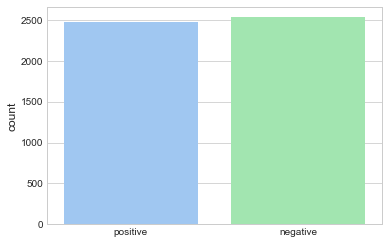

In [327]:
import seaborn as sns
sns.countplot(Y_train)

In [474]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from nltk.tokenize import word_tokenize
import networkx as nx
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import RandomWalk
from grakel.kernels import ShortestPath
from collections import defaultdict

class SVMClassifier:
    def __init__(self, kernel, C=None, gamma=None, coef=None, d=None):
        
        #implement initialisation
        self.clf = svm.SVC()
        self.kernel = kernel
        self.vectorizer = None
        
        # regularization parameter
        self.C = C # penalty parameter
        
        # kernel parameters
        self.gamma = gamma # kernel coef for rbf, poly, sigmoid
        self.coef = coef #independent term for polynomial and sigmoid kernels
        self.d = d # degree; for polynomial kernel

        self.vectorizer = TfidfVectorizer(min_df = 2, # remove words that appear too rarely
                                          max_df = 0.7, # remove words that appear too often
                                          ngram_range=(1,2), # 1-2 gram
#                                           max_features=5000,
                                          smooth_idf = True, # +1 to all frequencies, prevent division by zero
                                          sublinear_tf = True #use log for TF, clip extreme values
                                          )
        
    # define your own kernel here
    # Refer to the documentation here: https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
    
    # Implementation of kernels: https://github.com/gmum/pykernels/tree/master/pykernels
    
    def graphs_to_adjacency_lists(self,data):
        """
        Given a list of graphs, output a numpy.array
        containing their adjacency matices.
        """
        try:
            if data.ndim == 3:
                print('1')
                return np.array(data)
        except:
            try:
                print('2')
                return np.array([G.adjacency_matix for G in data])
            except:
                print('3')
                return np.array(data)
    
    def create_vocab_dict(self, X):
        d = defaultdict(dict)
        
        print('Creating vocab dictionary...')
        for review in tqdm(X):
            tokens = nlp(review)
            for token in tokens:
                word = token.lemma_
                if word not in d:
                    d[word] = len(d[word])
        
        print('Number of vocab: ', len(d))
        
        return d
    
    
    def create_graph(self, X, vocab_dict, window=3):
    
    ## Hyperparameter:
    ## window: 
    ## - represents co-occurence of words
    ## - typically 2 to 10 (p2 - https://aclanthology.org/S15-2093.pdf)
        graphs = []
        
        print('Creating graphs...')
        for review in tqdm(X):
            G = nx.Graph()
            tokens = nlp(review)
            # create nodes
            for i in range(len(tokens)):
                word = tokens[i].lemma_
                if word not in G.nodes():
                    G.add_node(word)
                    G.nodes[word]['label'] = vocab_dict[word]
                    print(vocab_dict[word])
            
            # create edges
            for i in range(len(tokens)):
                w1 = tokens[i].lemma_
                for j in range(i + 1, i + window):
                    if j < len(tokens):
                        w2 = tokens[j].lemma_
                        G.add_edge(w1, w2)
                        
            graphs.append(G)
        
        self.custom_graphs = graphs
        
        return graphs

    def custom_kernel(self, X, y):
        
        X = X.A
        y = y.A
        
        print('Computing custom kernel...')
        
        # 1. Spline kernel (85%)
        # ---------------- BEGIN ----------------#
#         kernel = np.ones((X.shape[0], y.shape[0]))
        
        
#         for d in tqdm(range(X.shape[1])):
#             column_1 = X[:, d].reshape(-1, 1)
#             column_2 = y[:, d].reshape(-1, 1)
#             #print(d)
            
#             c_prod = column_1 * column_2.T
#             #print(column_1.shape)
#             #print()
#             #print(column_2.shape)
#             c_sum = column_1 + column_2.T
            
#             c_min = np.minimum(column_1, column_2.T)
            
#             kernel *= 1. + c_prod + c_prod * c_min \
#                          - c_sum/2. * c_min ** 2. \
#                          + 1./3. * c_min ** 3.
        
        # ------------------ END -----------------#
        
        # 2. Histogram intersection kernel （0.86）
        # ---------------- BEGIN ----------------#
        kernel = np.zeros((X.shape[0], y.shape[0]))

        for d in tqdm(range(X.shape[1])):
            column_1 = X[:, d].reshape(-1, 1)
            column_2 = y[:, d].reshape(-1, 1)
            kernel += np.minimum(column_1, column_2.T)

        # ------------------ END -----------------#
        
        return kernel
    
    def fit(self, X, y):
        # training of the SVM
        # Ensure you call your own defined kernel here

        # Transform data into tfidf feature vectors
        X = self.vectorizer.fit_transform(X)

        # calling diff kernels
        if self.kernel == 'linear':
            self.clf = svm.SVC(kernel='linear', C=self.C)

        elif self.kernel == 'poly':
            self.clf = svm.SVC(kernel='poly', C=self.C, degree=self.d)

        elif self.kernel == 'rbf':
            # for hyperparameter tuning
            self.clf = svm.SVC(kernel='rbf', C=self.C, gamma=self.gamma)

        elif self.kernel == 'custom':
            self.clf = svm.SVC(kernel=self.custom_kernel, C=self.C)
        
        self.clf.fit(X,y)
    
    def predict(self, X):
        
        # prediction routine for the SVM
        X = self.vectorizer.transform(X)
        
        return self.clf.predict(X)

In [417]:
# self testing code - remove before submission
# Custom kernel - Splines

from sklearn.metrics import classification_report

custom_perf = []
custom_rpt = []

# Hyperparameter grid search with cross-validation
custom_sc = SVMClassifier(kernel='custom')
custom_kernel = custom_sc.custom_kernel

C_rng = np.logspace(-5,8,10,base=math.e)
params_grid = {'kernel': [custom_kernel],
               'C': C_rng}

custom_svc = svm.SVC()
custom_search = GridSearchCV(custom_svc, params_grid, cv=5, verbose=10, scoring='accuracy')
custom_X_train = custom_sc.vectorizer.fit_transform(X_train)
custom_search.fit(custom_X_train, Y_train)
print(custom_search.best_params_)
print(custom_search.best_estimator_)
print(custom_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.859 total time=17.3min
[CV 2/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.843 total time=17.0min
[CV 3/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.827 total time=17.4min
[CV 4/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.833 total time=17.5min
[CV 5/5; 1/10] START C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 1/10] END C=0.006737946999085469, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.829 total time=17.0min
[CV 1/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=17.7min
[CV 2/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.860 total time=16.6min
[CV 3/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.829 total time=16.6min
[CV 4/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=16.4min
[CV 5/5; 2/10] START C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 2/10] END C=0.028565500784550384, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.868 total time=16.8min
[CV 1/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.856 total time=15.9min
[CV 2/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.859 total time=15.7min
[CV 3/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.827 total time=15.7min
[CV 4/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.850 total time=15.8min
[CV 5/5; 3/10] START C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 3/10] END C=0.12110333239232973, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.868 total time=15.8min
[CV 1/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.832 total time=15.8min
[CV 2/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.852 total time=15.8min
[CV 3/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 4/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.835 total time=15.8min
[CV 5/5; 4/10] START C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 4/10] END C=0.5134171190325919, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.854 total time=15.8min
[CV 1/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=15.8min
[CV 2/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=15.8min
[CV 3/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=15.8min
[CV 4/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 5/5; 5/10] START C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 5/10] END C=2.176629931716248, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=15.9min
[CV 1/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=15.9min
[CV 2/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=15.8min
[CV 3/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=15.8min
[CV 4/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 5/5; 6/10] START C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 6/10] END C=9.227814352139523, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=15.8min
[CV 1/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=15.8min
[CV 2/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=15.9min
[CV 3/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=15.8min
[CV 4/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 5/5; 7/10] START C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 7/10] END C=39.12128399815319, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=15.8min
[CV 1/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=15.8min
[CV 2/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=15.9min
[CV 3/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=15.8min
[CV 4/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 5/5; 8/10] START C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 8/10] END C=165.85453534934933, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=15.9min
[CV 1/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=15.8min
[CV 2/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=15.9min
[CV 3/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=15.9min
[CV 4/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=15.8min
[CV 5/5; 9/10] START C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 9/10] END C=703.1396744863266, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=16.6min
[CV 1/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 1/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.823 total time=17.0min
[CV 2/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 2/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.851 total time=17.0min
[CV 3/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 3/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.836 total time=17.1min
[CV 4/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 4/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.830 total time=17.2min
[CV 5/5; 10/10] START C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

[CV 5/5; 10/10] END C=2980.957987041727, kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>;, score=0.853 total time=17.0min
Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

{'C': 0.028565500784550384, 'kernel': <bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f40656610>>}
SVC(C=0.028565500784550384,
    kernel=<bound method SVMClassifier.custom_kernel of <__main__.SVMClassifier object at 0x7f7f44ea81d0>>)
0.8526


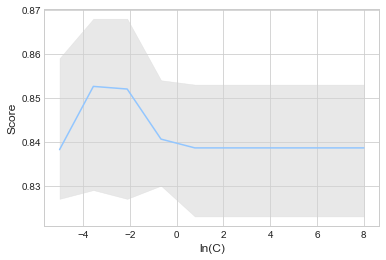

In [418]:
custom_df = pd.DataFrame.from_dict(custom_search.cv_results_)
custom_params = [np.log(np.array(custom_df.param_C, dtype='float'))]
plot_cv_results(custom_df, 'ln(C)', custom_params)

In [466]:
# plug in the best parameter found to test accuracy for test set

custom_sc = SVMClassifier(kernel='custom', C=0.0285655)
custom_sc.fit(X_train, Y_train)
custom_pred = custom_sc.predict(X_test)
print(classification_report(Y_test, custom_pred))

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing custom kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.82      0.85       731
    positive       0.84      0.89      0.86       769

    accuracy                           0.86      1500
   macro avg       0.86      0.85      0.85      1500
weighted avg       0.86      0.86      0.86      1500



Creating vocab dictionary...


  0%|          | 0/5000 [00:00<?, ?it/s]

Creating graphs...


  0%|          | 0/5000 [00:00<?, ?it/s]

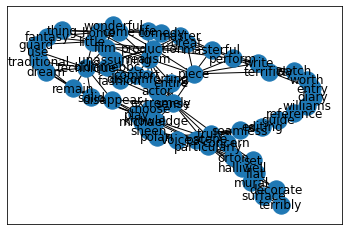

In [11]:
custom_sc.custom_kernel(X_train)
train_nx = custom_sc.custom_graphs

## Linear Kernel

In [304]:
# self testing code - remove before submission
# Hyperparameter tuning for linear kernel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import math

linear_perf = []
linear_rpt = []

C_rng = np.logspace(-5,8,20,base=math.e)

# Hyperparameter grid search with cross-validation

params_grid = {'kernel': ['linear'],
               'C': C_rng}

svc = svm.SVC()
linear_sc = SVMClassifier(kernel='linear')
linear_search = GridSearchCV(svc, params_grid, cv=5, verbose=10)
linear_X_train = linear_sc.vectorizer.fit_transform(X_train)
linear_search.fit(linear_X_train, Y_train)
print(linear_search.best_params_)
print(linear_search.best_estimator_)
print(linear_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 1/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  13.1s
[CV 2/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 2/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  12.6s
[CV 3/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 3/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.506 total time=  12.1s
[CV 4/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 4/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.507 total time=  12.5s
[CV 5/5; 1/20] START C=0.006737946999085469, kernel=linear......................
[CV 5/5; 1/20] END C=0.006737946999085469, kernel=linear;, score=0.507 total time=  12.3s
[CV 1/5; 2/20] START C=0.013356001111439869, kernel=linear......................
[C

[CV 4/5; 10/20] END C=3.1832246912598827, kernel=linear;, score=0.870 total time=  10.2s
[CV 5/5; 10/20] START C=3.1832246912598827, kernel=linear.......................
[CV 5/5; 10/20] END C=3.1832246912598827, kernel=linear;, score=0.870 total time=  10.8s
[CV 1/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 1/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.852 total time=  10.0s
[CV 2/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 2/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.867 total time=  10.1s
[CV 3/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 3/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.847 total time=  10.4s
[CV 4/5; 11/20] START C=6.3098080943943815, kernel=linear.......................
[CV 4/5; 11/20] END C=6.3098080943943815, kernel=linear;, score=0.870 total time=  10.2s
[CV 5/5; 11/20] START C=6.3098080943943815, kernel=linear....

[CV 3/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.847 total time=  11.7s
[CV 4/5; 20/20] START C=2980.957987041727, kernel=linear........................
[CV 4/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.870 total time=  11.8s
[CV 5/5; 20/20] START C=2980.957987041727, kernel=linear........................
[CV 5/5; 20/20] END C=2980.957987041727, kernel=linear;, score=0.870 total time=  11.8s
{'C': 0.40871514110598417, 'kernel': 'linear'}
SVC(C=0.40871514110598417, kernel='linear')
0.8666


In [475]:
# plug in the best parameter found to test accuracy for test set
#'''
linear_sc = SVMClassifier(kernel='linear', C=0.408715)
linear_sc.fit(X_train, Y_train)
linear_pred = linear_sc.predict(X_test)
print(classification_report(Y_test, linear_pred))
#'''

              precision    recall  f1-score   support

    negative       0.88      0.85      0.87       731
    positive       0.87      0.89      0.88       769

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



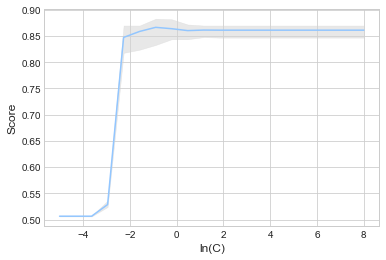

In [343]:
import matplotlib.pyplot as plt

def plot_cv_results(df, xlabel, params_list):
    min_scores = [min(df.split0_test_score[i], 
                      df.split1_test_score[i], 
                      df.split2_test_score[i],
                      df.split3_test_score[i],
                      df.split4_test_score[i]) for i in range(len(df))]

    max_scores = [max(df.split0_test_score[i], 
                      df.split1_test_score[i], 
                      df.split2_test_score[i],
                      df.split3_test_score[i],
                      df.split4_test_score[i]) for i in range(len(df))]
    
    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel('Score')
    for param in params_list:
        plt.plot(param, df.mean_test_score) 
        plt.fill_between(param, min_scores, max_scores, color='lightgrey', alpha=.5)
    plt.show()

linear_df = pd.DataFrame.from_dict(linear_search.cv_results_)
linear_params = [np.log(np.array(linear_df.param_C, dtype='float'))]
plot_cv_results(linear_df, 'ln(C)', linear_params)

### Results Analysis

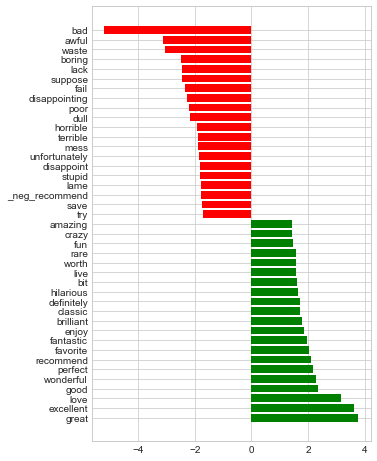

In [264]:
# visualize top features (only for linear svm classifiers)

from matplotlib import pyplot as plt
from sklearn import svm
from wordcloud import WordCloud

def visualize_importances(coef, names, top_features):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    pos_idx = -np.sort(-np.arange(len(imp)-top_features-1, len(imp)))
    neg_idx = -np.sort(-np.arange(0, top_features))
    show_idx = np.hstack([pos_idx, neg_idx])
    imp = [imp[i] for i in show_idx]
    names = [names[i] for i in show_idx]
    
    colors = ['red' if c < 0 else 'green' for c in imp]
    plt.figure(figsize=(5, 8))
    plt.barh(range(len(names)), imp, align='center', color=colors)
    plt.yticks(range(len(names)), names)
    plt.show()

def plot_wordcloud():
    # Display the generated image:
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
features_names = linear_sc.vectorizer.get_feature_names_out()
visualize_importances(linear_sc.clf.coef_.toarray()[0], features_names, top_features=20)


In [267]:
# Analyze misclassified samples

wrong_idx = [w for w in range(len(linear_pred)) if linear_pred[w] != Y_test[w]]
inspect_idx = wrong_idx[9]
print('predicted: ', linear_sc.predict([X_test[inspect_idx]]))
print('correct prediction: ', Y_test[inspect_idx])
print('review: ')
print(X_test[inspect_idx])

features_names = linear_sc.vectorizer.get_feature_names_out()
print(features_names)
print(len(features_names))
print(inspect_idx)
# get indices of X_test review words in the feature vector
inspect_idx_list = []
tokens = X_test[inspect_idx].split()
for token in tokens:
    #print(token)
    idx = np.where(features_names==token)[0]
    if idx.size>0:
        #print(idx)
        inspect_idx_list.append(*idx)
# for i in inspect_idx_list:
#     print(features_names[i], ' : ', linear_sc.clf.coef_.toarray()[0][i])
# print()


predicted:  ['positive']
correct prediction:  negative
review: 
broken dark horrorfest _NEG_slasher fill plenty broken glass mirror edgy thriller writer successful radiologist lena headly inter strange world life spiral control attend father richard jenkins birthday party guest stun mirror crash floor obvious reason thing strange witness spit image drive street car identical sneak doppelganger apartment find photo father drive away involve head collision mysteriously boyfriend _NEG_exact family friend _NEG_easy trust parallel world nightmare horrific break kudo figure _NEG_easy editing _NEG_tight lighting questionable player melvil poupard michelle duncan ulrich thomsen
['_neg_' '_neg_ability' '_neg_able' ... 'zucker' 'zue' 'zulu']
47365
49


## Task 1: Analysis on Linear Kernel Results

In [ ]:
train_file = "movie_review_train.csv"
test_file = "movie_review_test.csv"

# Read the CSV files for training and test sets
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

wrong_idx = [w for w in range(len(linear_pred)) if linear_pred[w] != Y_test[w]]
correct_idx = [w for w in range(len(linear_pred)) if linear_pred[w] == Y_test[w]]

raw_wrong_samples = [test.review[i] for i in wrong_idx]
raw_correct_samples = [test.review[i] for i in correct_idx]

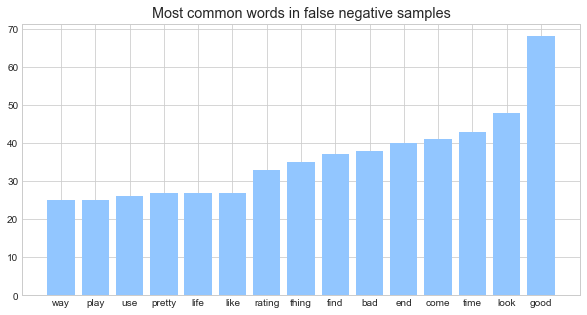

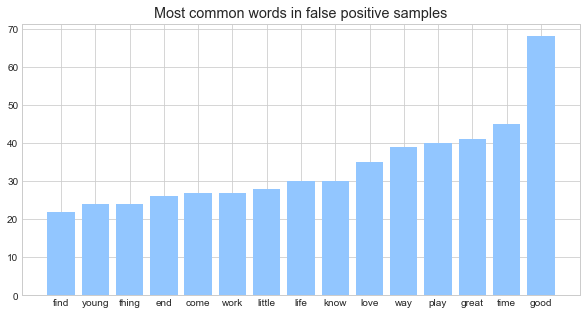

In [270]:
# find the most common words in misclassified samples
# map the feature value
from nltk.tokenize import word_tokenize

def sorted_count(reviews):
    words = []
    for review in reviews:
        tokens = word_tokenize(review)
        for word in tokens:
            words.append(word)
    unique, counts = np.unique(np.array(words), return_counts=True)
    sorted_indices = np.argsort(counts)
    sorted_unique = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    return sorted_unique, sorted_counts
    
fn_samples = [X_test[i] for i in wrong_idx if Y_test[i] == 'positive']
fp_samples = [X_test[i] for i in wrong_idx if Y_test[i] == 'negative']

fn_unique, fn_counts = sorted_count(fn_samples)
fp_unique, fp_counts = sorted_count(fp_samples)

plt.figure(figsize=(10, 5))
plt.title('Most common words in false negative samples')
plt.bar(fn_unique[-15:], fn_counts[-15:])
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Most common words in false positive samples')
plt.bar(fp_unique[-15:], fp_counts[-15:])
plt.show()


In [165]:
# 1. Number of tokens
def get_mean_len(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    samples = [nlp(review) for review in samples]
    return sum(len(review) for review in samples) / len(samples)

fn_mean_len = get_mean_len(X_test, Y_test, wrong_idx, 'positive')
fp_mean_len = get_mean_len(X_test, Y_test, wrong_idx, 'negative')
tn_mean_len = get_mean_len(X_test, Y_test, correct_idx, 'negative')
tp_mean_len = get_mean_len(X_test, Y_test, correct_idx, 'positive')
print("Ave length of tokenised false negative reviews: ", fn_mean_len)
print("Ave length of tokenised false positive reviews: ", fp_mean_len)
print("Ave length of tokenised false negative reviews: ", tn_mean_len)
print("Ave length of tokenised false positive reviews: ", tp_mean_len)

Ave length of tokenised false negative reviews:  83.05154639175258
Ave length of tokenised false positive reviews:  75.61855670103093
Ave length of tokenised false negative reviews:  86.74447949526814
Ave length of tokenised false positive reviews:  91.28125


In [166]:
count = lambda data, to_count: sum([1 for x in data if x in to_count])

# 2. Number of punctuations
def get_mean_punc(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    return sum(count(review, set(string.punctuation)) for review in samples) / len(samples)

fn_mean_punc = get_mean_punc(test.review, Y_test, wrong_idx, 'positive')
fp_mean_punc = get_mean_punc(test.review, Y_test, wrong_idx, 'negative')
tn_mean_punc = get_mean_punc(test.review, Y_test, correct_idx, 'negative')
tp_mean_punc = get_mean_punc(test.review, Y_test, correct_idx, 'positive')
print('Ave number of punctuation in false negative reviews: ', fn_mean_punc)
print('Ave number of punctuation in false positive reviews: ', fp_mean_punc)
print('Ave number of punctuation in true negative reviews: ', tn_mean_punc)
print('Ave number of punctuation in true positive reviews: ', tp_mean_punc)

Ave number of punctuation in false negative reviews:  50.51546391752577
Ave number of punctuation in false positive reviews:  45.98969072164948
Ave number of punctuation in true negative reviews:  56.33123028391167
Ave number of punctuation in true positive reviews:  52.822916666666664


In [272]:
# 3. Number of words trimmed
def get_mean_trim(X, X_trim, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    trim_samples = [X_trim[i] for i in indices if Y[i] == sent]
    return sum(((len(samples[i].split()) - len(trim_samples[i].split()))/len(samples[i].split())) \
               for i in range(len(samples))) / len(samples)

fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, wrong_idx, 'positive')
fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, wrong_idx, 'negative')
tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, correct_idx, 'negative')
tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, correct_idx, 'positive')
print('Ave percentage of words trimmed in false negative reviews: ', fn_mean_trim)
print('Ave percentage of words trimmed in false positive reviews: ', fp_mean_trim)
print('Ave percentage of words trimmed in true negative reviews: ', tn_mean_trim)
print('Ave percentage of words trimmed in true positive reviews: ', tp_mean_trim)

Ave percentage of words trimmed in false negative reviews:  0.6490222086970837
Ave percentage of words trimmed in false positive reviews:  0.6540684507160853
Ave percentage of words trimmed in true negative reviews:  0.656992751853729
Ave percentage of words trimmed in true positive reviews:  0.6429818487072312


In [250]:
#4. Number of negation words
def get_mean_dep(X, Y, indices, sent, dep):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.dep_ == dep])
    return count/len(samples)

fn_mean_neg = get_mean_dep(test.review, Y_test, wrong_idx, 'positive', 'neg')
fp_mean_neg = get_mean_dep(test.review, Y_test, wrong_idx, 'negative', 'neg')
tn_mean_neg = get_mean_dep(test.review, Y_test, correct_idx, 'negative', 'neg')
tp_mean_neg = get_mean_dep(test.review, Y_test, correct_idx, 'positive', 'neg')
print('Ave number of negation words in false negative reviews: ', fn_mean_neg)
print('Ave number of negation words in false positive reviews: ', fp_mean_neg)
print('Ave number of negation words in true negative reviews: ', tn_mean_neg)
print('Ave number of negation words in true positive reviews: ', tp_mean_neg)

Ave number of negation words in false negative reviews:  2.4948453608247423
Ave number of negation words in false positive reviews:  2.6082474226804124
Ave number of negation words in true negative reviews:  3.3738170347003154
Ave number of negation words in true positive reviews:  2.53125


In [251]:
#4. Number of adjectives
def get_mean_pos(X, Y, indices, sent, pos):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.pos_ == pos])
    return count/len(samples)

fn_mean_adj = get_mean_pos(test.review, Y_test, wrong_idx, 'positive', 'ADJ')
fp_mean_adj = get_mean_pos(test.review, Y_test, wrong_idx, 'negative', 'ADJ')
tn_mean_adj = get_mean_pos(test.review, Y_test, correct_idx, 'negative', 'ADJ')
tp_mean_adj = get_mean_pos(test.review, Y_test, correct_idx, 'positive', 'ADJ')
print('Ave number of adjectives in false negative reviews: ', fn_mean_adj)
print('Ave number of adjectives in false negative reviews: ', fp_mean_adj)
print('Ave number of adjectives in true negative reviews: ', tn_mean_adj)
print('Ave number of adjectives in true positive reviews: ', tp_mean_adj)

Ave number of adjectives in false negative reviews:  18.63917525773196
Ave number of adjectives in false negative reviews:  18.15463917525773
Ave number of adjectives in true negative reviews:  20.339116719242902
Ave number of adjectives in true positive reviews:  21.580357142857142


In [273]:
# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
analysis = {'Punctuations': [fp_mean_punc, tp_mean_punc, fn_mean_punc, tn_mean_punc],
            'Adjectives': [fp_mean_adj, tp_mean_adj, fn_mean_adj, tn_mean_adj],
            'Negation Words': [fp_mean_neg, tp_mean_neg, fn_mean_neg, tn_mean_neg],
            'Tokens': [fp_mean_len, tp_mean_len, fn_mean_len, tn_mean_len],
            'Words Trimmed':  [fp_mean_trim, tp_mean_trim, fn_mean_trim, tn_mean_trim]
}

analysis_df = pd.DataFrame(analysis, index=labels)

analysis_df.style.background_gradient(axis=0)

,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,45.989691,18.154639,2.608247,75.618557,0.654068
True Positive,52.822917,21.580357,2.531250,91.281250,0.642982
False Negative,50.515464,18.639175,2.494845,83.051546,0.649022
True Negative,56.331230,20.339117,3.373817,86.744479,0.656993


## RBF Kernel

In [331]:
# self testing code - remove before submission
## RBF kernel

from sklearn.metrics import classification_report

rbf_perf = []
rbf_rpt = []

# Hyperparameter tuning
C_rng = np.logspace(-5,8,20,base=math.e)
gamma_rng = np.logspace(-5,8,20,base=math.e)

params_grid = {'kernel':['rbf'],
               'C': C_rng,
              'gamma': gamma_rng}

rbf_svc = svm.SVC()
rbf_sc = SVMClassifier(kernel='rbf')
rbf_search = GridSearchCV(rbf_svc, params_grid, cv=5, verbose=10)
rbf_X_train = rbf_sc.vectorizer.fit_transform(X_train)
rbf_search.fit(rbf_X_train, Y_train)
print(rbf_search.best_params_)
print(rbf_search.best_estimator_)
print(rbf_search.best_score_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 1/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  13.5s
[CV 2/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  12.2s
[CV 3/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 3/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  12.2s
[CV 4/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 1/400] END C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  11.8s
[CV 5/5; 1/400] START C=0.006737946999085469, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 1/400] END C=0.006737946999085469, gam

[CV 2/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  11.5s
[CV 3/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  11.4s
[CV 4/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  11.6s
[CV 5/5; 9/400] START C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf
[CV 5/5; 9/400] END C=0.006737946999085469, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  11.4s
[CV 1/5; 10/400] START C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 10/400] END C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf;, score=0.506 total time=  11.4s
[CV 2/5; 10/400] START C=0.006737946999085469, gamma=3.1832246912598827, kernel=rbf
[CV 2/5; 10/

[CV 4/5; 17/400] END C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  13.3s
[CV 5/5; 17/400] START C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 17/400] END C=0.006737946999085469, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  12.7s
[CV 1/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 1/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  12.0s
[CV 2/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 2/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  13.1s
[CV 3/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 3/5; 18/400] END C=0.006737946999085469, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  11.6s
[CV 4/5; 18/400] START C=0.006737946999085469, gamma=758.679139848782, kernel=rbf
[CV 4/5; 18/400] END C

[CV 5/5; 25/400] END C=0.013356001111439869, gamma=0.10402147666803764, kernel=rbf;, score=0.507 total time=  12.5s
[CV 1/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  12.7s
[CV 2/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  12.7s
[CV 3/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.506 total time=  12.4s
[CV 4/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf
[CV 4/5; 26/400] END C=0.013356001111439869, gamma=0.20619202825140895, kernel=rbf;, score=0.507 total time=  12.3s
[CV 5/5; 26/400] START C=0.013356001111439869, gamma=0.20619202825140895, kernel

[CV 2/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  12.5s
[CV 3/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  12.3s
[CV 4/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  12.6s
[CV 5/5; 34/400] START C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 34/400] END C=0.013356001111439869, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  12.5s
[CV 1/5; 35/400] START C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf
[CV 1/5; 35/400] END C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  12.5s
[CV 2/5; 35/400] START C=0.013356001111439869, gamma=97.41180148195387, kernel=rbf
[CV 2/5;

[CV 4/5; 42/400] END C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  12.4s
[CV 5/5; 42/400] START C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 42/400] END C=0.026474349785326985, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  12.2s
[CV 1/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  12.4s
[CV 2/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  12.5s
[CV 3/5; 43/400] START C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf
[CV 3/5; 43/400] END C=0.026474349785326985, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  12.4s
[CV 4/5; 43/400] START C=0.026474349785326985, gamma=0.0264743497853269

[CV 5/5; 50/400] END C=0.026474349785326985, gamma=3.1832246912598827, kernel=rbf;, score=0.507 total time=  12.3s
[CV 1/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  12.7s
[CV 2/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  12.5s
[CV 3/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  12.1s
[CV 4/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 51/400] END C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  12.6s
[CV 5/5; 51/400] START C=0.026474349785326985, gamma=6.3098080943943815, kernel=rbf
[CV 5

[CV 2/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  12.6s
[CV 3/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 3/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  12.5s
[CV 4/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.507 total time=  12.6s
[CV 5/5; 59/400] START C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 59/400] END C=0.026474349785326985, gamma=1503.8585842871576, kernel=rbf;, score=0.507 total time=  12.6s
[CV 1/5; 60/400] START C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 60/400] END C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  12.4s
[CV 2/5; 60/400] START C=0.026474349785326985, gamma=2980.957987041727, kernel=rbf
[CV 2/5;

[CV 3/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.506 total time=  12.6s
[CV 4/5; 67/400] START C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf
[CV 4/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.507 total time=  12.1s
[CV 5/5; 67/400] START C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf
[CV 5/5; 67/400] END C=0.052477623407466346, gamma=0.40871514110598417, kernel=rbf;, score=0.507 total time=  13.1s
[CV 1/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 68/400] END C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf;, score=0.506 total time=  13.0s
[CV 2/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 68/400] END C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf;, score=0.506 total time=  13.4s
[CV 3/5; 68/400] START C=0.052477623407466346, gamma=0.8101577349324269, kernel=rbf


[CV 5/5; 75/400] END C=0.052477623407466346, gamma=97.41180148195387, kernel=rbf;, score=0.507 total time=  14.3s
[CV 1/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 1/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  15.8s
[CV 2/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 2/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  14.0s
[CV 3/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  13.8s
[CV 4/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 76/400] END C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  13.6s
[CV 5/5; 76/400] START C=0.052477623407466346, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 76/400

[CV 2/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.506 total time=  13.5s
[CV 3/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 3/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.506 total time=  13.7s
[CV 4/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 4/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.507 total time=  13.3s
[CV 5/5; 84/400] START C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf
[CV 5/5; 84/400] END C=0.10402147666803764, gamma=0.052477623407466346, kernel=rbf;, score=0.507 total time=  13.1s
[CV 1/5; 85/400] START C=0.10402147666803764, gamma=0.10402147666803764, kernel=rbf
[CV 1/5; 85/400] END C=0.10402147666803764, gamma=0.10402147666803764, kernel=rbf;, score=0.506 total time=  12.5s
[CV 2/5; 85/400] START C=0.10402147666803764, gamma=0.10402147666803764, kernel=rb

[CV 4/5; 92/400] END C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  13.5s
[CV 5/5; 92/400] START C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf
[CV 5/5; 92/400] END C=0.10402147666803764, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  12.5s
[CV 1/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 1/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  13.5s
[CV 2/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 2/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  12.3s
[CV 3/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 3/5; 93/400] END C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  12.3s
[CV 4/5; 93/400] START C=0.10402147666803764, gamma=24.792131281525027, kernel=rbf
[CV 4/5; 93/400

[CV 1/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  13.2s
[CV 2/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  13.3s
[CV 3/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 3/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.506 total time=  12.7s
[CV 4/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  11.8s
[CV 5/5; 101/400] START C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 101/400] END C=0.20619202825140895, gamma=0.006737946999085469, kernel=rbf;, score=0.507 total time=  13.3s
[CV 1/5; 102/400] START C=0.20619202825140895, gamma=0.0133560011114398

[CV 2/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  12.5s
[CV 3/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.506 total time=  12.4s
[CV 4/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  13.5s
[CV 5/5; 109/400] START C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf
[CV 5/5; 109/400] END C=0.20619202825140895, gamma=1.6058997806999291, kernel=rbf;, score=0.507 total time=  12.2s
[CV 1/5; 110/400] START C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 110/400] END C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf;, score=0.506 total time=  12.8s
[CV 2/5; 110/400] START C=0.20619202825140895, gamma=3.1832246912598827, kernel=rbf
[CV 2

[CV 4/5; 117/400] END C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  14.3s
[CV 5/5; 117/400] START C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 117/400] END C=0.20619202825140895, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  16.1s
[CV 1/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 1/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  13.9s
[CV 2/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 2/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  13.7s
[CV 3/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 3/5; 118/400] END C=0.20619202825140895, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  13.3s
[CV 4/5; 118/400] START C=0.20619202825140895, gamma=758.679139848782, kernel=rbf
[CV 4/5; 118/400] END 

[CV 5/5; 125/400] END C=0.40871514110598417, gamma=0.10402147666803764, kernel=rbf;, score=0.749 total time=  14.6s
[CV 1/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.868 total time=  12.6s
[CV 2/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.842 total time=  13.1s
[CV 3/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.815 total time=  12.5s
[CV 4/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf
[CV 4/5; 126/400] END C=0.40871514110598417, gamma=0.20619202825140895, kernel=rbf;, score=0.854 total time=  12.8s
[CV 5/5; 126/400] START C=0.40871514110598417, gamma=0.20619202825140895, kernel

[CV 2/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  13.3s
[CV 3/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  13.5s
[CV 4/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  12.7s
[CV 5/5; 134/400] START C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 134/400] END C=0.40871514110598417, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  13.2s
[CV 1/5; 135/400] START C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf
[CV 1/5; 135/400] END C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  14.0s
[CV 2/5; 135/400] START C=0.40871514110598417, gamma=97.41180148195387, kernel=rbf
[CV 2/5;

[CV 4/5; 142/400] END C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  13.5s
[CV 5/5; 142/400] START C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 142/400] END C=0.8101577349324269, gamma=0.013356001111439869, kernel=rbf;, score=0.507 total time=  14.1s
[CV 1/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  15.7s
[CV 2/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  14.0s
[CV 3/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf
[CV 3/5; 143/400] END C=0.8101577349324269, gamma=0.026474349785326985, kernel=rbf;, score=0.506 total time=  14.1s
[CV 4/5; 143/400] START C=0.8101577349324269, gamma=0.026474349785326985, kernel

[CV 1/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  13.6s
[CV 2/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  13.4s
[CV 3/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  13.8s
[CV 4/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  13.6s
[CV 5/5; 151/400] START C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf
[CV 5/5; 151/400] END C=0.8101577349324269, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  13.7s
[CV 1/5; 152/400] START C=0.8101577349324269, gamma=12.507341469611143, kernel=rbf
[CV 1/5; 152/40

[CV 3/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  12.5s
[CV 4/5; 159/400] START C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  12.9s
[CV 5/5; 159/400] START C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 159/400] END C=0.8101577349324269, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  12.8s
[CV 1/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 160/400] END C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  12.4s
[CV 2/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 2/5; 160/400] END C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  12.9s
[CV 3/5; 160/400] START C=0.8101577349324269, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 160/400] EN

[CV 5/5; 167/400] END C=1.6058997806999291, gamma=0.40871514110598417, kernel=rbf;, score=0.884 total time=  13.3s
[CV 1/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.871 total time=  12.3s
[CV 2/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.873 total time=  13.8s
[CV 3/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.839 total time=  12.9s
[CV 4/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 4/5; 168/400] END C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf;, score=0.872 total time=  16.3s
[CV 5/5; 168/400] START C=1.6058997806999291, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 168/4

[CV 2/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.509 total time=  13.3s
[CV 3/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  13.6s
[CV 4/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  13.2s
[CV 5/5; 176/400] START C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 176/400] END C=1.6058997806999291, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  13.7s
[CV 1/5; 177/400] START C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 177/400] END C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  14.7s
[CV 2/5; 177/400] START C=1.6058997806999291, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 177/400] END C=1

[CV 4/5; 184/400] END C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf;, score=0.870 total time=  12.9s
[CV 5/5; 184/400] START C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf
[CV 5/5; 184/400] END C=3.1832246912598827, gamma=0.052477623407466346, kernel=rbf;, score=0.875 total time=  11.6s
[CV 1/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 1/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.871 total time=  10.8s
[CV 2/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 2/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.869 total time=  10.3s
[CV 3/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[CV 3/5; 185/400] END C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf;, score=0.839 total time=  10.3s
[CV 4/5; 185/400] START C=3.1832246912598827, gamma=0.10402147666803764, kernel=rbf
[C

[CV 1/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.506 total time=  13.6s
[CV 2/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 2/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.509 total time=  13.3s
[CV 3/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 3/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.507 total time=  13.4s
[CV 4/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 4/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  13.7s
[CV 5/5; 193/400] START C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf
[CV 5/5; 193/400] END C=3.1832246912598827, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  13.7s
[CV 1/5; 194/400] START C=3.1832246912598827, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 194/40

[CV 3/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.834 total time=  14.7s
[CV 4/5; 201/400] START C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf
[CV 4/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.853 total time=  12.3s
[CV 5/5; 201/400] START C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf
[CV 5/5; 201/400] END C=6.3098080943943815, gamma=0.006737946999085469, kernel=rbf;, score=0.840 total time=  12.1s
[CV 1/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf
[CV 1/5; 202/400] END C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf;, score=0.873 total time=  13.5s
[CV 2/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf
[CV 2/5; 202/400] END C=6.3098080943943815, gamma=0.013356001111439869, kernel=rbf;, score=0.853 total time=  12.5s
[CV 3/5; 202/400] START C=6.3098080943943815, gamma=0.013356001111439869, kernel

[CV 5/5; 209/400] END C=6.3098080943943815, gamma=1.6058997806999291, kernel=rbf;, score=0.877 total time=  14.8s
[CV 1/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 1/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.846 total time=  13.3s
[CV 2/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 2/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.845 total time=  13.7s
[CV 3/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 3/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.837 total time=  12.1s
[CV 4/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 4/5; 210/400] END C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf;, score=0.841 total time=  12.5s
[CV 5/5; 210/400] START C=6.3098080943943815, gamma=3.1832246912598827, kernel=rbf
[CV 5/5; 210/40

[CV 2/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  17.5s
[CV 3/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 3/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.506 total time=  12.3s
[CV 4/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 4/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  13.5s
[CV 5/5; 218/400] START C=6.3098080943943815, gamma=758.679139848782, kernel=rbf
[CV 5/5; 218/400] END C=6.3098080943943815, gamma=758.679139848782, kernel=rbf;, score=0.508 total time=  13.2s
[CV 1/5; 219/400] START C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf
[CV 1/5; 219/400] END C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  14.3s
[CV 2/5; 219/400] START C=6.3098080943943815, gamma=1503.8585842871576, kernel=rbf
[CV 2/5; 219/400] END C=6.309

[CV 4/5; 226/400] END C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf;, score=0.867 total time=  14.5s
[CV 5/5; 226/400] START C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf
[CV 5/5; 226/400] END C=12.507341469611143, gamma=0.20619202825140895, kernel=rbf;, score=0.874 total time=  13.9s
[CV 1/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 1/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.865 total time=  12.6s
[CV 2/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 2/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.870 total time=  13.3s
[CV 3/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 3/5; 227/400] END C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf;, score=0.848 total time=  12.9s
[CV 4/5; 227/400] START C=12.507341469611143, gamma=0.40871514110598417, kernel=rbf
[CV 4

[CV 1/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.506 total time=  14.1s
[CV 2/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 2/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.509 total time=  14.1s
[CV 3/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 3/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.507 total time=  13.3s
[CV 4/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 4/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.508 total time=  14.6s
[CV 5/5; 235/400] START C=12.507341469611143, gamma=97.41180148195387, kernel=rbf
[CV 5/5; 235/400] END C=12.507341469611143, gamma=97.41180148195387, kernel=rbf;, score=0.508 total time=  18.0s
[CV 1/5; 236/400] START C=12.507341469611143, gamma=193.0902883381129, kernel=rbf
[CV 1/5; 236/400] END C=1

[CV 3/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.844 total time=  12.0s
[CV 4/5; 243/400] START C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf
[CV 4/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.870 total time=  11.4s
[CV 5/5; 243/400] START C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf
[CV 5/5; 243/400] END C=24.792131281525027, gamma=0.026474349785326985, kernel=rbf;, score=0.877 total time=  13.4s
[CV 1/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf
[CV 1/5; 244/400] END C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf;, score=0.855 total time=  13.6s
[CV 2/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf
[CV 2/5; 244/400] END C=24.792131281525027, gamma=0.052477623407466346, kernel=rbf;, score=0.868 total time=  12.5s
[CV 3/5; 244/400] START C=24.792131281525027, gamma=0.052477623407466346, kernel

[CV 5/5; 251/400] END C=24.792131281525027, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  14.4s
[CV 1/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 1/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.506 total time=  13.6s
[CV 2/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 2/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.509 total time=  14.0s
[CV 3/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 3/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.507 total time=  13.4s
[CV 4/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 4/5; 252/400] END C=24.792131281525027, gamma=12.507341469611143, kernel=rbf;, score=0.508 total time=  14.2s
[CV 5/5; 252/400] START C=24.792131281525027, gamma=12.507341469611143, kernel=rbf
[CV 5/5; 252/40

[CV 2/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  15.6s
[CV 3/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  13.0s
[CV 4/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 4/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  13.3s
[CV 5/5; 260/400] START C=24.792131281525027, gamma=2980.957987041727, kernel=rbf
[CV 5/5; 260/400] END C=24.792131281525027, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  13.2s
[CV 1/5; 261/400] START C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf
[CV 1/5; 261/400] END C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf;, score=0.864 total time=  10.2s
[CV 2/5; 261/400] START C=49.143119261097524, gamma=0.006737946999085469, kernel=rbf
[CV 2/5; 261/400

[CV 4/5; 268/400] END C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf;, score=0.873 total time=  12.0s
[CV 5/5; 268/400] START C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 268/400] END C=49.143119261097524, gamma=0.8101577349324269, kernel=rbf;, score=0.880 total time=  13.1s
[CV 1/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 1/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.877 total time=  14.9s
[CV 2/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 2/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.873 total time=  14.7s
[CV 3/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 3/5; 269/400] END C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf;, score=0.838 total time=  13.7s
[CV 4/5; 269/400] START C=49.143119261097524, gamma=1.6058997806999291, kernel=rbf
[CV 4/5; 269/40

[CV 1/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  15.4s
[CV 2/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.509 total time=  14.1s
[CV 3/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 3/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.507 total time=  13.1s
[CV 4/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 4/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  13.7s
[CV 5/5; 277/400] START C=49.143119261097524, gamma=382.7447894740212, kernel=rbf
[CV 5/5; 277/400] END C=49.143119261097524, gamma=382.7447894740212, kernel=rbf;, score=0.508 total time=  12.4s
[CV 1/5; 278/400] START C=49.143119261097524, gamma=758.679139848782, kernel=rbf
[CV 1/5; 278/400] END C=49

[CV 3/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.845 total time=  13.5s
[CV 4/5; 285/400] START C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf
[CV 4/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.867 total time=  13.7s
[CV 5/5; 285/400] START C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf
[CV 5/5; 285/400] END C=97.41180148195387, gamma=0.10402147666803764, kernel=rbf;, score=0.870 total time=  13.3s
[CV 1/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 286/400] END C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf;, score=0.857 total time=  12.7s
[CV 2/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 2/5; 286/400] END C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf;, score=0.870 total time=  12.5s
[CV 3/5; 286/400] START C=97.41180148195387, gamma=0.20619202825140895, kernel=rbf
[CV 3/5; 286/40

[CV 5/5; 293/400] END C=97.41180148195387, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  13.4s
[CV 1/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  14.7s
[CV 2/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 2/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.509 total time=  12.6s
[CV 3/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  12.1s
[CV 4/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 294/400] END C=97.41180148195387, gamma=49.143119261097524, kernel=rbf;, score=0.508 total time=  12.0s
[CV 5/5; 294/400] START C=97.41180148195387, gamma=49.143119261097524, kernel=rbf
[CV 5/5; 294/400] END C=9

[CV 3/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.848 total time=  11.1s
[CV 4/5; 302/400] START C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf
[CV 4/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.869 total time=  12.0s
[CV 5/5; 302/400] START C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 302/400] END C=193.0902883381129, gamma=0.013356001111439869, kernel=rbf;, score=0.870 total time=  14.9s
[CV 1/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 303/400] END C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf;, score=0.853 total time=  13.8s
[CV 2/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 2/5; 303/400] END C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf;, score=0.866 total time=  14.6s
[CV 3/5; 303/400] START C=193.0902883381129, gamma=0.026474349785326985, kernel=rbf
[CV 3

[CV 5/5; 310/400] END C=193.0902883381129, gamma=3.1832246912598827, kernel=rbf;, score=0.843 total time=  12.1s
[CV 1/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  16.8s
[CV 2/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  15.0s
[CV 3/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  13.8s
[CV 4/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 311/400] END C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf;, score=0.508 total time=  13.4s
[CV 5/5; 311/400] START C=193.0902883381129, gamma=6.3098080943943815, kernel=rbf
[CV 5/5; 311/400] END C=1

[CV 3/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  13.3s
[CV 4/5; 319/400] START C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  13.3s
[CV 5/5; 319/400] START C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 319/400] END C=193.0902883381129, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  13.4s
[CV 1/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 320/400] END C=193.0902883381129, gamma=2980.957987041727, kernel=rbf;, score=0.506 total time=  13.7s
[CV 2/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 2/5; 320/400] END C=193.0902883381129, gamma=2980.957987041727, kernel=rbf;, score=0.508 total time=  13.6s
[CV 3/5; 320/400] START C=193.0902883381129, gamma=2980.957987041727, kernel=rbf
[CV 3/5; 320/400] END C=193.09

[CV 5/5; 327/400] END C=382.7447894740212, gamma=0.40871514110598417, kernel=rbf;, score=0.879 total time=  12.6s
[CV 1/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.870 total time=  13.1s
[CV 2/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.869 total time=  13.1s
[CV 3/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.839 total time=  12.9s
[CV 4/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 4/5; 328/400] END C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf;, score=0.873 total time=  13.1s
[CV 5/5; 328/400] START C=382.7447894740212, gamma=0.8101577349324269, kernel=rbf
[CV 5/5; 328/400] END C=

[CV 3/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  13.3s
[CV 4/5; 336/400] START C=382.7447894740212, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  13.4s
[CV 5/5; 336/400] START C=382.7447894740212, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 336/400] END C=382.7447894740212, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  13.4s
[CV 1/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 337/400] END C=382.7447894740212, gamma=382.7447894740212, kernel=rbf;, score=0.506 total time=  13.8s
[CV 2/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 2/5; 337/400] END C=382.7447894740212, gamma=382.7447894740212, kernel=rbf;, score=0.509 total time=  13.8s
[CV 3/5; 337/400] START C=382.7447894740212, gamma=382.7447894740212, kernel=rbf
[CV 3/5; 337/400] END C=382.7447894

[CV 1/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.855 total time=  12.2s
[CV 2/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 2/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.868 total time=  12.2s
[CV 3/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 3/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.845 total time=  11.9s
[CV 4/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 4/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.867 total time=  12.1s
[CV 5/5; 345/400] START C=758.679139848782, gamma=0.10402147666803764, kernel=rbf
[CV 5/5; 345/400] END C=758.679139848782, gamma=0.10402147666803764, kernel=rbf;, score=0.870 total time=  12.3s
[CV 1/5; 346/400] START C=758.679139848782, gamma=0.20619202825140895, kernel=rbf
[CV 1/5; 346/400] END C=7

[CV 4/5; 353/400] END C=758.679139848782, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  11.9s
[CV 5/5; 353/400] START C=758.679139848782, gamma=24.792131281525027, kernel=rbf
[CV 5/5; 353/400] END C=758.679139848782, gamma=24.792131281525027, kernel=rbf;, score=0.508 total time=  11.8s
[CV 1/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 1/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.506 total time=  11.8s
[CV 2/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 2/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.509 total time=  12.1s
[CV 3/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 3/5; 354/400] END C=758.679139848782, gamma=49.143119261097524, kernel=rbf;, score=0.507 total time=  11.6s
[CV 4/5; 354/400] START C=758.679139848782, gamma=49.143119261097524, kernel=rbf
[CV 4/5; 354/400] END C=758.6791398

[CV 2/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.866 total time=  10.9s
[CV 3/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 3/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.848 total time=  10.4s
[CV 4/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 4/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.869 total time=  10.5s
[CV 5/5; 362/400] START C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf
[CV 5/5; 362/400] END C=1503.8585842871576, gamma=0.013356001111439869, kernel=rbf;, score=0.870 total time=  10.5s
[CV 1/5; 363/400] START C=1503.8585842871576, gamma=0.026474349785326985, kernel=rbf
[CV 1/5; 363/400] END C=1503.8585842871576, gamma=0.026474349785326985, kernel=rbf;, score=0.853 total time=  10.5s
[CV 2/5; 363/400] START C=1503.8585842871576, gamma=0.026474349785326985, kernel

[CV 4/5; 370/400] END C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf;, score=0.841 total time=  14.0s
[CV 5/5; 370/400] START C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf
[CV 5/5; 370/400] END C=1503.8585842871576, gamma=3.1832246912598827, kernel=rbf;, score=0.843 total time=  13.6s
[CV 1/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 1/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.506 total time=  13.4s
[CV 2/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 2/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.509 total time=  13.1s
[CV 3/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 3/5; 371/400] END C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf;, score=0.507 total time=  12.3s
[CV 4/5; 371/400] START C=1503.8585842871576, gamma=6.3098080943943815, kernel=rbf
[CV 4/5; 371/40

[CV 1/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  14.1s
[CV 2/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 2/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  13.4s
[CV 3/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 3/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.506 total time=  14.1s
[CV 4/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 4/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  13.1s
[CV 5/5; 379/400] START C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf
[CV 5/5; 379/400] END C=1503.8585842871576, gamma=1503.8585842871576, kernel=rbf;, score=0.508 total time=  13.5s
[CV 1/5; 380/400] START C=1503.8585842871576, gamma=2980.957987041727, kernel=rbf
[CV 1/5; 380/400

[CV 3/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.848 total time=  13.3s
[CV 4/5; 387/400] START C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf
[CV 4/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.867 total time=  14.6s
[CV 5/5; 387/400] START C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf
[CV 5/5; 387/400] END C=2980.957987041727, gamma=0.40871514110598417, kernel=rbf;, score=0.879 total time=  14.2s
[CV 1/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 1/5; 388/400] END C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf;, score=0.870 total time=  12.6s
[CV 2/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 2/5; 388/400] END C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf;, score=0.869 total time=  12.3s
[CV 3/5; 388/400] START C=2980.957987041727, gamma=0.8101577349324269, kernel=rbf
[CV 3/5; 388/400] EN

[CV 1/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.506 total time=  16.9s
[CV 2/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 2/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.509 total time=  13.5s
[CV 3/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 3/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.507 total time=  12.2s
[CV 4/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 4/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  13.8s
[CV 5/5; 396/400] START C=2980.957987041727, gamma=193.0902883381129, kernel=rbf
[CV 5/5; 396/400] END C=2980.957987041727, gamma=193.0902883381129, kernel=rbf;, score=0.508 total time=  12.3s
[CV 1/5; 397/400] START C=2980.957987041727, gamma=382.7447894740212, kernel=rbf
[CV 1/5; 397/400] END C=2980.957987

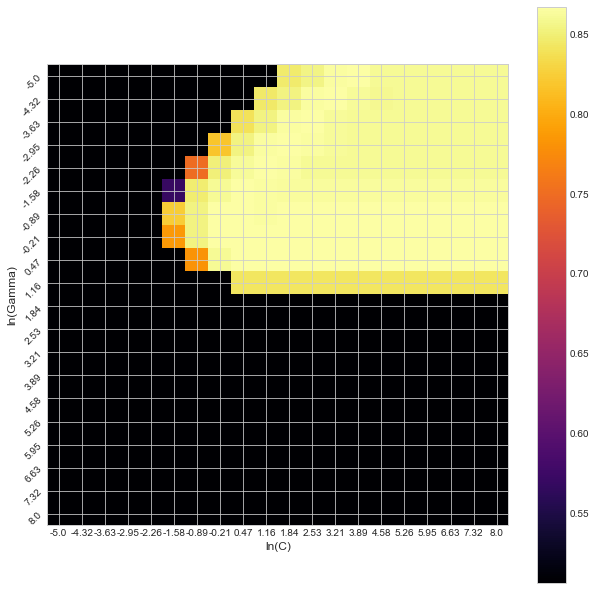

In [393]:
rbf_df = pd.DataFrame.from_dict(rbf_search.cv_results_)

rbf_scores = rbf_df.mean_test_score
rbf_scores = np.array(rbf_scores).reshape(len(gamma_rng),len(C_rng)).T

# Make a nice figure
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rbf_scores, interpolation='nearest', cmap=plt.get_cmap('inferno'))
plt.ylabel('ln(Gamma)')
plt.xlabel('ln(C)')
plt.colorbar()
plt.yticks(np.arange(len(gamma_rng)), np.round(np.log(gamma_rng),2), rotation=45)
plt.xticks(np.arange(len(C_rng)), np.round(np.log(C_rng), 2))
plt.show()

In [467]:
# plug in the best parameter found to test accuracy for test set

rbf_sc = SVMClassifier(kernel='rbf', C=1.606, gamma=0.206)
rbf_sc.fit(X_train, Y_train)
rbf_pred = rbf_sc.predict(X_test)
print(classification_report(Y_test, rbf_pred))


              precision    recall  f1-score   support

    negative       0.87      0.86      0.87       731
    positive       0.87      0.88      0.88       769

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [370]:
# self testing code - remove before submission
# Polynomial kernel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

C_rng = np.logspace(-5,8,20,base=math.e)
d_range = np.linspace(1, 4, 4)

# Hyperparameter tuning
params_grid = {'kernel':['poly'],
               'C': C_rng,
              'degree': d_range}

poly_svc = svm.SVC()
poly_sc = SVMClassifier(kernel='poly')
poly_search = GridSearchCV(poly_svc, params_grid, cv=5, verbose=10)
poly_X_train = poly_sc.vectorizer.fit_transform(X_train)
poly_search.fit(poly_X_train, Y_train)
print(poly_search.best_params_)
print(poly_search.best_estimator_)
print(poly_search.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 1/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  12.0s
[CV 2/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 2/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  12.8s
[CV 3/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 3/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.506 total time=  14.8s
[CV 4/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 4/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.507 total time=  13.1s
[CV 5/5; 1/80] START C=0.006737946999085469, degree=1.0, kernel=poly............
[CV 5/5; 1/80] END C=0.006737946999085469, degree=1.0, kernel=poly;, score=0.507 total time=  14.2s
[CV 1/5; 2/80] START C=0.00673794

[CV 1/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  14.0s
[CV 2/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 2/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  13.9s
[CV 3/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 3/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.506 total time=  12.7s
[CV 4/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 4/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.507 total time=  12.3s
[CV 5/5; 10/80] START C=0.026474349785326985, degree=2.0, kernel=poly...........
[CV 5/5; 10/80] END C=0.026474349785326985, degree=2.0, kernel=poly;, score=0.507 total time=  12.7s
[CV 1/5; 11/80] START C=0.026474349785326985, degree=3.0, kernel=poly...........
[CV 1/5; 11/80] END C=0.026474349785326985, degree=3.0, kernel=poly;, score=0.506 total ti

[CV 2/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.506 total time=  14.0s
[CV 3/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 3/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.506 total time=  13.2s
[CV 4/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 4/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.507 total time=  15.9s
[CV 5/5; 19/80] START C=0.10402147666803764, degree=3.0, kernel=poly............
[CV 5/5; 19/80] END C=0.10402147666803764, degree=3.0, kernel=poly;, score=0.507 total time=  15.0s
[CV 1/5; 20/80] START C=0.10402147666803764, degree=4.0, kernel=poly............
[CV 1/5; 20/80] END C=0.10402147666803764, degree=4.0, kernel=poly;, score=0.506 total time=  12.4s
[CV 2/5; 20/80] START C=0.10402147666803764, degree=4.0, kernel=poly............
[CV 2/5; 20/80] END C=0.10402147666803764, degree=4.0, kernel=poly;, score=0.506 total time=  1

[CV 3/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.506 total time=  13.0s
[CV 4/5; 28/80] START C=0.40871514110598417, degree=4.0, kernel=poly............
[CV 4/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.507 total time=  12.7s
[CV 5/5; 28/80] START C=0.40871514110598417, degree=4.0, kernel=poly............
[CV 5/5; 28/80] END C=0.40871514110598417, degree=4.0, kernel=poly;, score=0.507 total time=  15.4s
[CV 1/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 1/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.858 total time=  14.6s
[CV 2/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 2/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.867 total time=  10.1s
[CV 3/5; 29/80] START C=0.8101577349324269, degree=1.0, kernel=poly.............
[CV 3/5; 29/80] END C=0.8101577349324269, degree=1.0, kernel=poly;, score=0.844 total time=  10.1

[CV 4/5; 37/80] END C=3.1832246912598827, degree=1.0, kernel=poly;, score=0.870 total time=  13.2s
[CV 5/5; 37/80] START C=3.1832246912598827, degree=1.0, kernel=poly.............
[CV 5/5; 37/80] END C=3.1832246912598827, degree=1.0, kernel=poly;, score=0.870 total time=  12.6s
[CV 1/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 1/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.863 total time=  13.5s
[CV 2/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 2/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.864 total time=  13.2s
[CV 3/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 3/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.842 total time=  13.2s
[CV 4/5; 38/80] START C=3.1832246912598827, degree=2.0, kernel=poly.............
[CV 4/5; 38/80] END C=3.1832246912598827, degree=2.0, kernel=poly;, score=0.862 total time=  12.6s
[

[CV 5/5; 46/80] END C=12.507341469611143, degree=2.0, kernel=poly;, score=0.857 total time=  14.8s
[CV 1/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 1/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.592 total time=  13.9s
[CV 2/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 2/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.586 total time=  17.0s
[CV 3/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 3/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.602 total time=  14.8s
[CV 4/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 4/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.594 total time=  18.7s
[CV 5/5; 47/80] START C=12.507341469611143, degree=3.0, kernel=poly.............
[CV 5/5; 47/80] END C=12.507341469611143, degree=3.0, kernel=poly;, score=0.613 total time=  15.9s
[

[CV 1/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.509 total time=  14.6s
[CV 2/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 2/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.515 total time=  15.7s
[CV 3/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 3/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.514 total time=  13.5s
[CV 4/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 4/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.513 total time=  15.6s
[CV 5/5; 56/80] START C=49.143119261097524, degree=4.0, kernel=poly.............
[CV 5/5; 56/80] END C=49.143119261097524, degree=4.0, kernel=poly;, score=0.516 total time=  14.1s
[CV 1/5; 57/80] START C=97.41180148195387, degree=1.0, kernel=poly..............
[CV 1/5; 57/80] END C=97.41180148195387, degree=1.0, kernel=poly;, score=0.852 total time=  12.1s
[C

[CV 2/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.867 total time=  14.5s
[CV 3/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 3/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.847 total time=  12.5s
[CV 4/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 4/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.870 total time=  12.8s
[CV 5/5; 65/80] START C=382.7447894740212, degree=1.0, kernel=poly..............
[CV 5/5; 65/80] END C=382.7447894740212, degree=1.0, kernel=poly;, score=0.870 total time=  15.0s
[CV 1/5; 66/80] START C=382.7447894740212, degree=2.0, kernel=poly..............
[CV 1/5; 66/80] END C=382.7447894740212, degree=2.0, kernel=poly;, score=0.863 total time=  13.0s
[CV 2/5; 66/80] START C=382.7447894740212, degree=2.0, kernel=poly..............
[CV 2/5; 66/80] END C=382.7447894740212, degree=2.0, kernel=poly;, score=0.864 total time=  12.5s
[CV 3/5

[CV 3/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.842 total time=  13.6s
[CV 4/5; 74/80] START C=1503.8585842871576, degree=2.0, kernel=poly.............
[CV 4/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.862 total time=  13.8s
[CV 5/5; 74/80] START C=1503.8585842871576, degree=2.0, kernel=poly.............
[CV 5/5; 74/80] END C=1503.8585842871576, degree=2.0, kernel=poly;, score=0.857 total time=  13.6s
[CV 1/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 1/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.592 total time=  13.1s
[CV 2/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 2/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.586 total time=  13.2s
[CV 3/5; 75/80] START C=1503.8585842871576, degree=3.0, kernel=poly.............
[CV 3/5; 75/80] END C=1503.8585842871576, degree=3.0, kernel=poly;, score=0.602 total time=  12.9s
[

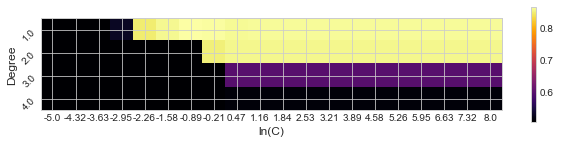

In [414]:
poly_df = pd.DataFrame.from_dict(poly_search.cv_results_)

poly_scores = poly_df.mean_test_score
poly_scores = np.array(poly_scores).reshape(len(C_rng), len(d_range)).T

# Make a nice figure

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(poly_scores, interpolation='nearest', cmap=plt.get_cmap('inferno'))
plt.ylabel('Degree')
plt.xlabel('ln(C)')
plt.colorbar(shrink=0.2)
plt.yticks(np.arange(len(d_range)),d_range, rotation=45)
plt.xticks(np.arange(len(C_rng)), np.round(np.log(C_rng), 2))
plt.show()

In [468]:
# plug in the best parameter found to test accuracy for test set

poly_sc = SVMClassifier(kernel='poly', C=0.408715, d=1)
poly_sc.fit(X_train, Y_train)
poly_pred = poly_sc.predict(X_test)
print(classification_report(Y_test, poly_pred))

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87       731
    positive       0.87      0.89      0.88       769

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [180]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score  
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

In [100]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

NameError: name 'linear_kernel' is not defined

### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [4]:
# Adaboost tutorial: https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class BoostingClassifier:
    # You need to implement this classifier. 
    def __init__(self):
        import numpy as np
        #implement initialisation
        
        self.T = # number of boosting rounds
        
    def fit(self, X,y):
        #implement training of the boosting classifier 
        
        
        
        return 
    def predict(self, X):
        # implement prediction of the boosting classifier
        return

In [423]:
class AdaBoost2:
    
    def __init__(self,n_clf=50):
        self.n_clf=n_clf
        
    def fit(self,X,y):
        
        n_samples,n_features=X.shape
        w=np.full(n_samples,(1/n_samples))
        self.clfs=[]
        self.alpha=[]
        
        for _ in range(self.n_clf):
            
            clf=DecisionTreeClassifier(max_depth=3)
            clf=clf.fit(X, y,sample_weight=w)
            min_error=float('inf')
            
           
            predictions=clf.predict(X)
            missclassified=w[y!=predictions]
            error=sum(missclassified)

            if error>0.5:
                error=1-error
                
            if error < min_error:
                min_error=error
                

            EPS=1e-10           
            self.alpha.append(0.5*np.log((1-error)/(error+EPS)))
            predictions=clf.predict(X)
    
            
            asd4=list()
            e=-(0.5*np.log((1-error)/(error+EPS)))
            for i in range(len(predictions)):
                if predictions[i]==y[i]:
                    asd4.append(1)
                else:
                    asd4.append(-1)
                    
            
            w*=np.exp(e*np.array(asd4))
            w/=np.sum(w)
            
            self.clfs.append(clf)
            

    def predict(self,X):
        
        clf_preds=list()
        for index in range(len(self.alpha)):
            asd=self.clfs[index]
            res=asd.predict(X)
            res2=[int(i) for i in res]
            clf_preds.append(self.alpha[index]*np.array(res2))
        y_pred=np.sum(clf_preds,axis=0)
        y_pred=np.sign(y_pred)
        y_pred=[str(i) for i in y_pred]
        for i in range(len(y_pred)):
            if y_pred[i]=="-1.0":
                y_pred[i]="-1"
            else:
                y_pred[i]="1"
        return y_pred

In [436]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
vector_train = vectorizer.transform(X_train)
print(vector_train[0])

mapping={'positive':1, 'negative':-1}

y_train_transform = np.zeros_like(Y_train)

for key in mapping:
    y_train_transform[Y_train==key] = mapping[key]


dff=pd.DataFrame(vector_train)
clf=AdaBoost2(n_clf=50)
clf.fit(dff,y_train_transform)

  (0, 31671)	0.10818801445530814
  (0, 30836)	0.18707119552352705
  (0, 30778)	0.05332136304214798
  (0, 30466)	0.04178638476413439
  (0, 30041)	0.12247681214644954
  (0, 29853)	0.08897869813048045
  (0, 29629)	0.04520395482854856
  (0, 29557)	0.08097659867962835
  (0, 29222)	0.06267162977714762
  (0, 28995)	0.11504529743750065
  (0, 28839)	0.03566860560086897
  (0, 28484)	0.07251900808734031
  (0, 28107)	0.0847934860865645
  (0, 27728)	0.14905765115265024
  (0, 27702)	0.06869009253083821
  (0, 27439)	0.06646468745546123
  (0, 27404)	0.08408368453040124
  (0, 26511)	0.07938796234916816
  (0, 25998)	0.1123928750294708
  (0, 25963)	0.0597956902898491
  (0, 25928)	0.045940100701201136
  (0, 25809)	0.07175715622137316
  (0, 25747)	0.089982409603464
  (0, 25740)	0.08516181072354431
  (0, 25665)	0.11829160010253356
  :	:
  (0, 9366)	0.059095211416524136
  (0, 8992)	0.1023089379124921
  (0, 8134)	0.0905114877663666
  (0, 7791)	0.053962349803572604
  (0, 7790)	0.06508749337839144
  (0, 7745)	0

ValueError: setting an array element with a sequence.

In [428]:
y_pred=clf.predict(dff_test)
acc=accuracy(Y_test, Y_pred)
print("Accuracy :",acc)

NameError: name 'dff_test' is not defined

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [5]:
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc

In [ ]:
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")